
# Modified Bateman (Dreher) + PyMC Integration
This notebook provides:
- A **modified Bateman** closed-form solution (after R. Dreher) that is robust for equal/near-equal half-lives and includes branching.
- A demo (As-60 chain) with a plot and CSV export.
- A **PyMC** model builder that uses the modified Bateman solution to compute **expected counts per time bin** with a **Poisson** likelihood and **softmax** branching ratios.

Notes:
- Times in **seconds**; background is a **rate** in counts/second.
- Sampling cell is commented to avoid long runs by default.


In [13]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pymc as pm
import aesara
import aesara.tensor as at

%matplotlib inline
plt.rcParams["figure.figsize"] = (8,5)
LN2 = np.log(2.0)


## Modified Bateman (Dreher) — general solver

In [14]:

from math import isfinite, factorial

def modified_bateman_populations_at_times(times, T, R, N0):
    """General Dreher 'modified Bateman' for a linear chain: times -> populations.
    T: [T1, T2, ...] half-lives (s), R: [R1, R2, ...] branch factors on each link.
    Returns array shape (len(times), ncols) with column 0 = t, columns 1.. = N_i(t).
    """
    T = [0.0] + list(T)   # 1-based
    R = [0.0] + list(R)
    # chain length
    nn = 1
    for idx in range(1, len(T)):
        if T[idx] == 0: break
        nn = idx + 1
    # decay constants
    k = [0.0]*nn
    for i in range(1, nn):
        if T[i] > 1e99 or not isfinite(T[i]): k[i] = 0.0
        else: k[i] = LN2 / T[i]

    times = np.asarray(times, dtype=float)
    nt = len(times)
    out = np.zeros((nt, nn), dtype=float)
    out[:,0] = times

    for i in range(1, nn):
        # distinct lambdas up to i
        kd = []
        mult = []
        for qi in range(1, i+1):
            lam = k[qi]
            merged = False
            for j in range(len(kd)):
                if abs(kd[j]-lam) <= 1e-15*max(1.0,abs(kd[j]),abs(lam)):
                    mult[j]+=1; merged=True; break
            if not merged:
                kd.append(lam); mult.append(1)
        me = len(kd)

        # front factor N0 * Π R[j]*λ[j]
        Nbr = N0
        for j in range(1, i):
            Nbr *= R[j] * (LN2/T[j] if (T[j] < 1e99 and isfinite(T[j])) else 0.0)

        for j in range(me):
            # build V[0..mult[j]-1] via Leibniz sums
            V = [0.0]*mult[j]
            denom_inv = 1.0
            for p in range(me):
                if p!=j: denom_inv /= (kd[p]-kd[j])**mult[p]
            V[0] = denom_inv
            for m in range(1, mult[j]):
                S_acc = 0.0
                for h in range(m):
                    S = 0.0
                    for p in range(me):
                        if p!=j: S += mult[p]/(kd[p]-kd[j])**(h+1)
                    S_acc += V[m-1-h]*S / factorial(m-1-h)
                V[m] = S_acc*factorial(m-1)
            sign = -1 if (mult[j]-1)%2==1 else 1

            for it, tt in enumerate(times):
                S = 0.0
                for m in range(mult[j]):
                    S += V[m]*((-tt)**(mult[j]-1-m))/(factorial(mult[j]-1-m)*factorial(m))
                out[it,i] += S*np.exp(-kd[j]*tt)*sign
        out[:,i] *= Nbr
    return out  # [t, N1, N2, ...]


## Expected activity and binned counts

In [15]:

def total_activity_parent_only(times, parent_half_life, N0):
    lam = np.log(2.0) / parent_half_life
    N_parent = N0 * np.exp(-lam * times)
    return lam * N_parent  # A_parent(t)

def total_activity_with_branches(times, A0, parentT, d0, d1, d2, b_vec, include_parent=True):
    times = np.asarray(times, dtype=float)
    A_total = np.zeros_like(times, dtype=float)
    if include_parent:
        lam_p = np.log(2.0) / parentT
        A_total += lam_p * A0 * np.exp(-lam_p * times)
    for key, Td in daughTs.items():
        b = b_vec.get(key, 0.0)
        if b <= 0: continue
        T = [parentT, Td]; R = [1.0, b]
        M = modified_bateman_populations_at_times(times, T, R, N0=A0)
        lam_d = np.log(2.0) / Td
        A_total += lam_d * M[:, 2]
    return A_total

def expected_counts_per_bin(times_center_s, bin_width_s, A0, parentT, daughTs, b_vec,
                            background_rate=0.0, oversample_factor=1):
    times_center_s = np.asarray(times_center_s, dtype=float)
    dt = float(bin_width_s)
    if oversample_factor <= 1:
        A_mid = total_activity_with_branches(times_center_s, A0, parentT, daughTs, b_vec, include_parent=True)
        return A_mid * dt + background_rate * dt
    nb = len(times_center_s)
    lam_counts = np.zeros(nb, dtype=float)
    sub = oversample_factor
    for i, tc in enumerate(times_center_s):
        t0 = tc - 0.5 * dt; t1 = tc + 0.5 * dt
        ts = np.linspace(t0, t1, sub + 1)
        A_sub = total_activity_with_branches(ts, A0, parentT, daughTs, b_vec, include_parent=True)
        lam_counts[i] = np.trapz(A_sub, ts) + background_rate * dt
    return lam_counts


## PyMC model builder (generic Op; use Slice/Metropolis)

In [87]:
import numpy as np
import pymc as pm
import aesara.tensor as at

def build_bateman_pymc_model_nuts_ms_uniform(bin_centers_ms, bin_width_ms, y_counts,
                                              df_rebinned, priors=None):
    c = np.asarray(bin_centers_ms, dtype=float)
    w = float(bin_width_ms)
    y = np.asarray(y_counts, dtype=int)
    # --- data-driven guesses from your arrays ---
    width_ms   = float(desired_bin_width)           # 1.0
    t0_ms      = float(centers_ms[0])               # ~0.5 if bins are centered
    first_bin  = float(counts[0])

    # background from late bins (or use t<0 side if you have it)
    bg_per_bin = float(np.median(counts[-10:]))     # ~ 1.32e4 … 1.38e4
    bg_ms_guess = bg_per_bin / width_ms            # counts/ms

    # parent guess using first bin and a rough half-life (adjust if you prefer)
    T_parent_guess_ms =8.0
    lam = np.log(2.0) / T_parent_guess_ms          # 1/ms
    net0_rate = max(first_bin/width_ms - bg_ms_guess, 1.0)  # counts/ms
    A0_guess  = net0_rate / (lam * np.exp(-lam*t0_ms))
    print(bg_ms_guess, A0_guess)
    eps = 1e-8
    bg_lo, bg_hi = 0.6*bg_ms_guess, 1.5*bg_ms_guess         # ~ ±40% around baseline
    A0_lo, A0_hi = eps, 10.0*A0_guess                       # wide, data-scaled

    

    with pm.Model() as model:
        # --- Uniform priors (bounded positive) ---
        bg_ms = pm.LogNormal("backgroundRate_ms", mu=np.log(14000.), sigma=0.15)
        A0 = pm.LogNormal("A0", mu=np.log(A0_guess), sigma=0.15)


        parentT_ms = pm.LogNormal(
            "parentT_ms",
            mu=np.log(priors.get("parentT_mu_ms", 8.0)),
            sigma=priors.get("parentT_sigma_ln", 0.2)
        )
        d0_ms = pm.LogNormal("daugh0nT_ms", mu=np.log(priors.get("d0_mu_ms", 90.2)),
                             sigma=priors.get("d0_sigma_ln", 0.05))
        d1_ms = pm.LogNormal("daugh1nT_ms", mu=np.log(priors.get("d1_mu_ms", 80.4)),
                             sigma=priors.get("d1_sigma_ln", 0.05))
        d2_ms = pm.LogNormal("daugh2nT_ms", mu=np.log(priors.get("d2_mu_ms", 270.0)),
                             sigma=priors.get("d2_sigma_ln", 0.05))
        
        # d0_ms = pm.TruncatedNormal("daugh0nT_ms", mu=90.2,  sigma=0.9,  lower=1e-6)
        # d1_ms = pm.TruncatedNormal("daugh1nT_ms", mu=80.4,  sigma=0.4,  lower=1e-6)
        # d2_ms = pm.TruncatedNormal("daugh2nT_ms", mu=270.0, sigma=2.0,  lower=1e-6)


        # logits = pm.Normal("logits", mu=priors.get("logits_mu", 0.0),
        #                    sigma=priors.get("logits_sigma", 1.5), shape=3)
        # b = pm.Deterministic("b", at.nnet.softmax(logits))  # [b0n,b1n,b2n]


        b_mu = np.asarray(priors.get("b_mu", [1, 1,1]), dtype=float)  # must be >0
        b_mu = np.clip(b_mu, 1e-12, None)  # avoid log(0)

        # log-space stdev (single value or length-3 vector)
        b_sigma_ln = priors.get("b_sigma_ln", 0.5)
        
        b_raw = pm.LogNormal(
            "b_raw",
            mu=np.log(b_mu),          # log of your prior medians
            sigma=b_sigma_ln,         # log-space stdev
            shape=3
        )

        # Normalize to the simplex (sum to 1)
        eps = 1e-12
        b = pm.Deterministic("b", (b_raw + eps) / at.sum(b_raw + eps))
        # --- data ---
        c_data = pm.MutableData("bin_centers_ms", c)
        w_data = pm.MutableData("bin_width_ms", np.array(w, dtype=float))

        ln2   = at.log(2.0)
        lam_p = ln2 / parentT_ms
        Np    = A0 * at.exp(-lam_p * c_data)
        A_par = lam_p * Np  # counts/ms

        def daughter_activity_ms(dT_ms, b_k):
            lam_d  = ln2 / dT_ms
            delta  = lam_d - lam_p
            exp_p  = at.exp(-lam_p * c_data)
            exp_d  = at.exp(-lam_d * c_data)
            Nd_std = A0 * b_k * (lam_p / delta) * (exp_p - exp_d)
            Nd_eq  = A0 * b_k * lam_p * c_data * exp_p
            eps_eq = 1e-12
            use_eq = at.lt(at.abs_(delta), eps_eq * (1.0 + at.abs_(lam_p) + at.abs_(lam_d)))
            Nd     = at.switch(use_eq, Nd_eq, Nd_std)
            return lam_d * Nd  # counts/ms

        A_tot_ms = (A_par
                    + daughter_activity_ms(d0_ms, b[0])
                    + daughter_activity_ms(d1_ms, b[1])
                    + daughter_activity_ms(d2_ms, b[2]))
        
        mu = (A_tot_ms + bg_ms) * w_data  # counts per bin
        pm.Poisson("y_obs", mu=mu, observed=y)
        # eta_sd = pm.HalfNormal("eta_sd", sigma=0.3)
        # eta    = pm.Normal("eta", 0, eta_sd, shape=len(y))
        # pm.Poisson("y_obs", mu=mu * at.exp(eta), observed=y)


    return model


In [92]:
import numpy as np

def total_activity_with_branches(times_ms, N0, parentT_ms, daughTs_ms, b_vec, include_parent=True):
    """
    NumPy (evaluation) helper for a parent → {0n,1n,2n,...} single-link network.

    Parameters
    ----------
    times_ms : array-like
        Times in ms.
    N0 : float
        Initial parent population (NOT activity at t=0).
    parentT_ms : float
        Parent half-life in ms.
    daughTs_ms : dict
        Mapping like {"0n": T0_ms, "1n": T1_ms, "2n": T2_ms}.
    b_vec : dict
        Mapping like {"0n": b0, "1n": b1, "2n": b2}. (Doesn't need to sum to 1, but usually does.)
    include_parent : bool
        Whether to add the parent activity term.

    Returns
    -------
    A_total_ms : ndarray
        Total activity (counts per ms) at each time in `times_ms`.
    """
    t = np.asarray(times_ms, dtype=float)
    A = np.zeros_like(t, dtype=float)

    ln2   = np.log(2.0)
    lam_p = ln2 / float(parentT_ms)

    if include_parent:
        # A_parent(t) = λ_p * N0 * exp(-λ_p t)
        A += lam_p * N0 * np.exp(-lam_p * t)

    exp_p = np.exp(-lam_p * t)

    for key, Td_ms in daughTs_ms.items():
        b     = float(b_vec.get(key, 0.0))
        if b <= 0.0:
            continue
        lam_d = ln2 / float(Td_ms)
        delta = lam_d - lam_p
        exp_d = np.exp(-lam_d * t)

        # N_d(t) with correct λ_d → λ_p limit
        Nd_std = N0 * b * (lam_p / delta) * (exp_p - exp_d)
        Nd_eq  = N0 * b * lam_p * t * exp_p
        use_eq = np.isclose(delta, 0.0, rtol=1e-12, atol=1e-12 * (1 + abs(lam_p) + abs(lam_d)))
        Nd     = np.where(use_eq, Nd_eq, Nd_std)

        A += lam_d * Nd  # A_d(t) = λ_d N_d(t)

    return A


In [93]:
import aesara.tensor as at

def _daughter_activity_ms_ae(t_ms, N0, parentT_ms, daughT_ms, b_k):
    """
    Aesara version of single daughter activity A_d(t) (counts/ms) with proper λ_d≈λ_p limit.

    A_d(t) = λ_d * N_d(t),
    N_d(t) = N0 b_k [ λ_p / (λ_d - λ_p) ] [ e^{-λ_p t} - e^{-λ_d t} ],
    limit λ_d→λ_p: N_d(t) → N0 b_k λ_p t e^{-λ_p t}.
    """
    ln2   = at.log(2.0)
    lam_p = ln2 / parentT_ms
    lam_d = ln2 / daughT_ms
    delta = lam_d - lam_p

    exp_p = at.exp(-lam_p * t_ms)
    exp_d = at.exp(-lam_d * t_ms)

    Nd_std = N0 * b_k * (lam_p / delta) * (exp_p - exp_d)
    Nd_eq  = N0 * b_k * lam_p * t_ms * exp_p

    # tolerance scaled to magnitudes to stay stable for tiny/large rates
    tol = 1e-12 * (1 + at.abs_(lam_p) + at.abs_(lam_d))
    use_eq = at.lt(at.abs_(delta), tol)

    Nd = at.switch(use_eq, Nd_eq, Nd_std)
    return lam_d * Nd  # activity (counts per ms)


def modified_bateman_total_activity_ms_ae(t_ms, N0, parentT_ms, d0_ms, d1_ms, d2_ms, b_vec, include_parent=True):
    """
    Aesara total activity (counts/ms) for parent → {0n,1n,2n}, using branching fractions b_vec[0], b_vec[1], b_vec[2].
    """
    ln2   = at.log(2.0)
    lam_p = ln2 / parentT_ms
    exp_p = at.exp(-lam_p * t_ms)

    A_parent = lam_p * N0 * exp_p if include_parent else at.zeros_like(t_ms)

    A0 = _daughter_activity_ms_ae(t_ms, N0, parentT_ms, d0_ms, b_vec[0])
    A1 = _daughter_activity_ms_ae(t_ms, N0, parentT_ms, d1_ms, b_vec[1])
    A2 = _daughter_activity_ms_ae(t_ms, N0, parentT_ms, d2_ms, b_vec[2])

    return A_parent + A0 + A1 + A2


In [99]:
import numpy as np

def normal_to_lognormal(mu_lin: float, sigma_lin: float):
    """
    Convert linear-space mean & std (mu_lin, sigma_lin) to lognormal (mu_log, sigma_log)
    for use in pm.LogNormal(mu=mu_log, sigma=sigma_log).

    Requires: mu_lin > 0, sigma_lin > 0
    """
    if mu_lin <= 0 or sigma_lin <= 0:
        raise ValueError("mu_lin and sigma_lin must be positive for a LogNormal prior.")
    sigma_log = np.sqrt(np.log(1.0 + (sigma_lin / mu_lin) ** 2))
    mu_log = np.log(mu_lin) - 0.5 * sigma_log**2
    return float(mu_log), float(sigma_log)


In [118]:
import aesara.tensor as at

def bin_integrated_counts_ms_ae(
    c_ms, w_ms,
    N0, parentT_ms,
    d0_ms, d1_ms, d2_ms,
    b_vec, backgroundRate_ms,
    include_parent=True,
):
    """
    Analytic ∫ A(t) dt per bin in ms, using modified Bateman for parent→{0n,1n,2n}.
    Returns expected counts per bin (NOT rate).

    A_parent(t) = λ_p N0 e^{-λ_p t}
    A_d(t)      = N0 b_k λ_d λ_p/(λ_d-λ_p) [ e^{-λ_p t}/λ_p - e^{-λ_d t}/λ_d ]'
                 (integrated closed-form below)
    Degenerate limit λ_d → λ_p handled explicitly.
    """
    c = at.as_tensor_variable(c_ms)
    w = at.as_tensor_variable(w_ms)
    a = c - 0.5 * w   # bin start
    b = c + 0.5 * w   # bin end

    ln2   = at.log(2.0)
    lam_p = ln2 / parentT_ms

    # Parent counts per bin: ∫_a^b λ_p N0 e^{-λ_p t} dt = N0 (e^{-λ_p a} - e^{-λ_p b})
    parent_counts = N0 * (at.exp(-lam_p * a) - at.exp(-lam_p * b))
    counts = parent_counts if include_parent else at.zeros_like(c)

    def daughter_counts_one(dT_ms, b_k):
        lam_d  = ln2 / dT_ms
        delta  = lam_d - lam_p
        exp_p_a, exp_p_b = at.exp(-lam_p * a), at.exp(-lam_p * b)
        exp_d_a, exp_d_b = at.exp(-lam_d * a), at.exp(-lam_d * b)

        # Standard closed-form (stable when |delta| not tiny):
        # ∫_a^b A_d(t) dt = N0 b_k [ λ_d/(λ_d-λ_p) (e^{-λ_p a}-e^{-λ_p b})
        #                         - λ_p/(λ_d-λ_p) (e^{-λ_d a}-e^{-λ_d b}) ]
        std = N0 * b_k * (
            (lam_d / delta) * (exp_p_a - exp_p_b)
            - (lam_p / delta) * (exp_d_a - exp_d_b)
        )

        # Degenerate limit λ_d → λ_p:
        # A_d(t) → N0 b_k λ_p^2 t e^{-λ_p t}
        # ∫ t e^{-λ t} dt = -(t e^{-λ t})/λ - e^{-λ t}/λ^2
        # ⇒ ∫_a^b A_d dt = N0 b_k [ (λ_p a + 1) e^{-λ_p a} - (λ_p b + 1) e^{-λ_p b} ]
        deg = N0 * b_k * (
            (lam_p * a + 1.0) * exp_p_a - (lam_p * b + 1.0) * exp_p_b
        )

        tol = 1e-12 * (1 + at.abs_(lam_p) + at.abs_(lam_d))
        use_deg = at.lt(at.abs_(delta), tol)
        return at.switch(use_deg, deg, std)

    counts += daughter_counts_one(d0_ms, b_vec[0])
    counts += daughter_counts_one(d1_ms, b_vec[1])
    counts += daughter_counts_one(d2_ms, b_vec[2])

    # Constant background integrates to bg_rate * width
    counts += backgroundRate_ms * w

    # Safety clamp
    return at.clip(counts, 1e-12, np.inf)


In [119]:
import numpy as np
import pymc as pm
import aesara.tensor as at

def normal_to_lognormal(mu_lin: float, sigma_lin: float):
    if mu_lin <= 0 or sigma_lin <= 0:
        raise ValueError("mu_lin and sigma_lin must be positive for a LogNormal prior.")
    sigma_log = np.sqrt(np.log(1.0 + (sigma_lin / mu_lin) ** 2))
    mu_log = np.log(mu_lin) - 0.5 * sigma_log**2
    return float(mu_log), float(sigma_log)

def build_bateman_pymc_model_lognormal_from_linearHL_integrated(
    c, w, y,
    parentT_mu_ms: float = 8.0,
    parentT_sigma_ms: float = 4.0,
    daughT_mu_ms = (6.4, 7.2, 11.4),
    daughT_sigma_ms = (0.3, 0.3, 0.6),
    include_parent: bool = True,
    use_dirichlet: bool = False,
    bg_tail_bins: int = 10,
):
    c = np.asarray(c, dtype=float)
    y = np.asarray(y, dtype=int)
    w = np.asarray(w, dtype=float)
    if w.ndim == 0:
        w = np.full_like(c, float(w))

    # Convert linear -> log for LogNormal priors
    par_mu_log, par_sigma_log = normal_to_lognormal(parentT_mu_ms, parentT_sigma_ms)
    d0_mu_log, d0_sigma_log   = normal_to_lognormal(daughT_mu_ms[0], daughT_sigma_ms[0])
    d1_mu_log, d1_sigma_log   = normal_to_lognormal(daughT_mu_ms[1], daughT_sigma_ms[1])
    d2_mu_log, d2_sigma_log   = normal_to_lognormal(daughT_mu_ms[2], daughT_sigma_ms[2])

    with pm.Model() as model:
        # Initial parent population (NOT activity)
        N0 = pm.HalfNormal("N0", sigma=np.maximum(10.0, 5.0 * (y.max() + 1.0)))

        # Half-life priors (LogNormal, calibrated from linear inputs)
        parentT_ms = pm.LogNormal("parentT_ms", mu=par_mu_log, sigma=par_sigma_log)
        d0_ms = pm.LogNormal("daugh0nT_ms", mu=d0_mu_log, sigma=d0_sigma_log)
        d1_ms = pm.LogNormal("daugh1nT_ms", mu=d1_mu_log, sigma=d1_sigma_log)
        d2_ms = pm.LogNormal("daugh2nT_ms", mu=d2_mu_log, sigma=d2_sigma_log)

        # Branching prior
        if use_dirichlet:
            alpha = np.array([1,1,1]) * 50.0
            b = pm.Dirichlet("b", a=alpha)
        else:
            b_mu = np.array([1,1,1], dtype=float)
            b_raw = pm.LogNormal("b_raw", mu=np.log(b_mu), sigma=0.5, shape=3)
            b = pm.Deterministic("b", (b_raw + 1e-12) / at.sum(b_raw + 1e-12))

        # Background prior anchored to tail median
        tail = y[-bg_tail_bins:] if y.size >= bg_tail_bins else y
        bg_per_bin = float(np.median(tail)) if tail.size > 0 else 0.0
        bg_ms_guess = max(bg_per_bin / float(np.mean(w)), 1e-6)
        backgroundRate_ms = pm.LogNormal("backgroundRate_ms", mu=np.log(bg_ms_guess), sigma=0.7)

        # Analytic bin integrals
        mu_counts = bin_integrated_counts_ms_ae(
            c_ms=c, w_ms=w,
            N0=N0, parentT_ms=parentT_ms,
            d0_ms=d0_ms, d1_ms=d1_ms, d2_ms=d2_ms,
            b_vec=b, backgroundRate_ms=backgroundRate_ms,
            include_parent=include_parent,
        )

        # Likelihood
        pm.Poisson("y_obs", mu=mu_counts, observed=y)

        # Convenience deterministics
        pm.Deterministic("b0n", b[0])
        pm.Deterministic("b1n", b[1])
        pm.Deterministic("b2n", b[2])
        pm.Deterministic("b_sum_1n2n", b[1] + b[2])

    return model


In [181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import aesara.tensor as at
# Load the tab-separated file
df = pd.read_csv("hist_33Na_with_error.csv", sep="\t")
df = df.rename(columns={"# BinCenter": "BinCenter"})
df["BinContent"] = df["BinContent"].str.replace(",", "").astype(float)
df["BinError"] = df["BinError"].str.replace(",", "").astype(float)
df.head()
# Compute original bin width
diffs = df["BinCenter"].diff().dropna().unique()
bin_width = round(diffs[0], 5)
print(f"Original bin width: {bin_width} ms")

# Set desired bin width (user can modify this value)
desired_bin_width = 2
width_ms= desired_bin_width
print(f"Desired bin width: {desired_bin_width} ms")
rebin_factor = int(desired_bin_width / bin_width)

if len(df) % rebin_factor != 0:
    df = df.iloc[:-(len(df) % rebin_factor)]

# Rebin data
df_rebinned = df.groupby(np.arange(len(df)) // rebin_factor).agg({
    "BinCenter": "mean",
    "BinContent": "sum",
    "BinError": lambda x: np.sqrt(np.sum(x**2))
}).reset_index(drop=True)

df_rebinned.head()



Original bin width: 0.5 ms
Desired bin width: 2 ms


,BinCenter,BinContent,BinError
0,-99.0,10355.0,101.759547
1,-97.0,10607.0,102.990256
2,-95.0,10355.0,101.759516
3,-93.0,10352.0,101.744793
4,-91.0,10354.0,101.754573


In [125]:
# --- 1) Keep only t >= 0 for the decay fit ---
df_pos1 = df_rebinned[df_rebinned["BinCenter"] >= 0].copy()
df_pos = df_pos1[df_pos1["BinCenter"]<=40].copy()
# --- 2) Build arrays (ms → s) ---
centers_ms = df_pos["BinCenter"].to_numpy(dtype=float)
counts     = np.round(df_pos["BinContent"].to_numpy(dtype=float)).astype(int)

# Your chosen rebin width in ms (the one you just used)
width_ms = float(desired_bin_width)

centers_s = centers_ms 
width_s   = width_ms

# Sanity: Poisson needs nonnegative integers
counts[counts < 0] = 0
# Background prior scale from negative side (counts/ms)
bg_per_bin     = float(df_rebinned.loc[df_rebinned["BinCenter"] < 0, "BinContent"].mean())
bg_rate_mu_ms  = bg_per_bin / width_ms if width_ms > 0 else bg_per_bin

model_ms = build_bateman_pymc_model_lognormal_from_linearHL_integrated(centers_ms, width_ms, counts,
                                             parentT_mu_ms=8.0,
                                             parentT_sigma_ms= 40,
                                             daughT_mu_ms =(90.2, 80.4,270.0),
                                             daughT_sigma_ms=(0.9, 0.4, 2.0),
                                             include_parent=True,
                                             use_dirichlet=True,
                                             bg_tail_bins=20
                                             )

with model_ms:
    idata = pm.sample(
        draws=300, tune=150, chains=4, cores=4,
        target_accept=0.995, init="jitter+adapt_diag",
        random_seed=42, return_inferencedata=True
    )


Only 300 samples in chain.


Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [N0, parentT_ms, daugh0nT_ms, daugh1nT_ms, daugh2nT_ms, b, backgroundRate_ms]
INFO:pymc:NUTS: [N0, parentT_ms, daugh0nT_ms, daugh1nT_ms, daugh2nT_ms, b, backgroundRate_ms]


Sampling 4 chains for 150 tune and 300 draw iterations (600 + 1_200 draws total) took 82 seconds.
INFO:pymc:Sampling 4 chains for 150 tune and 300 draw iterations (600 + 1_200 draws total) took 82 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.


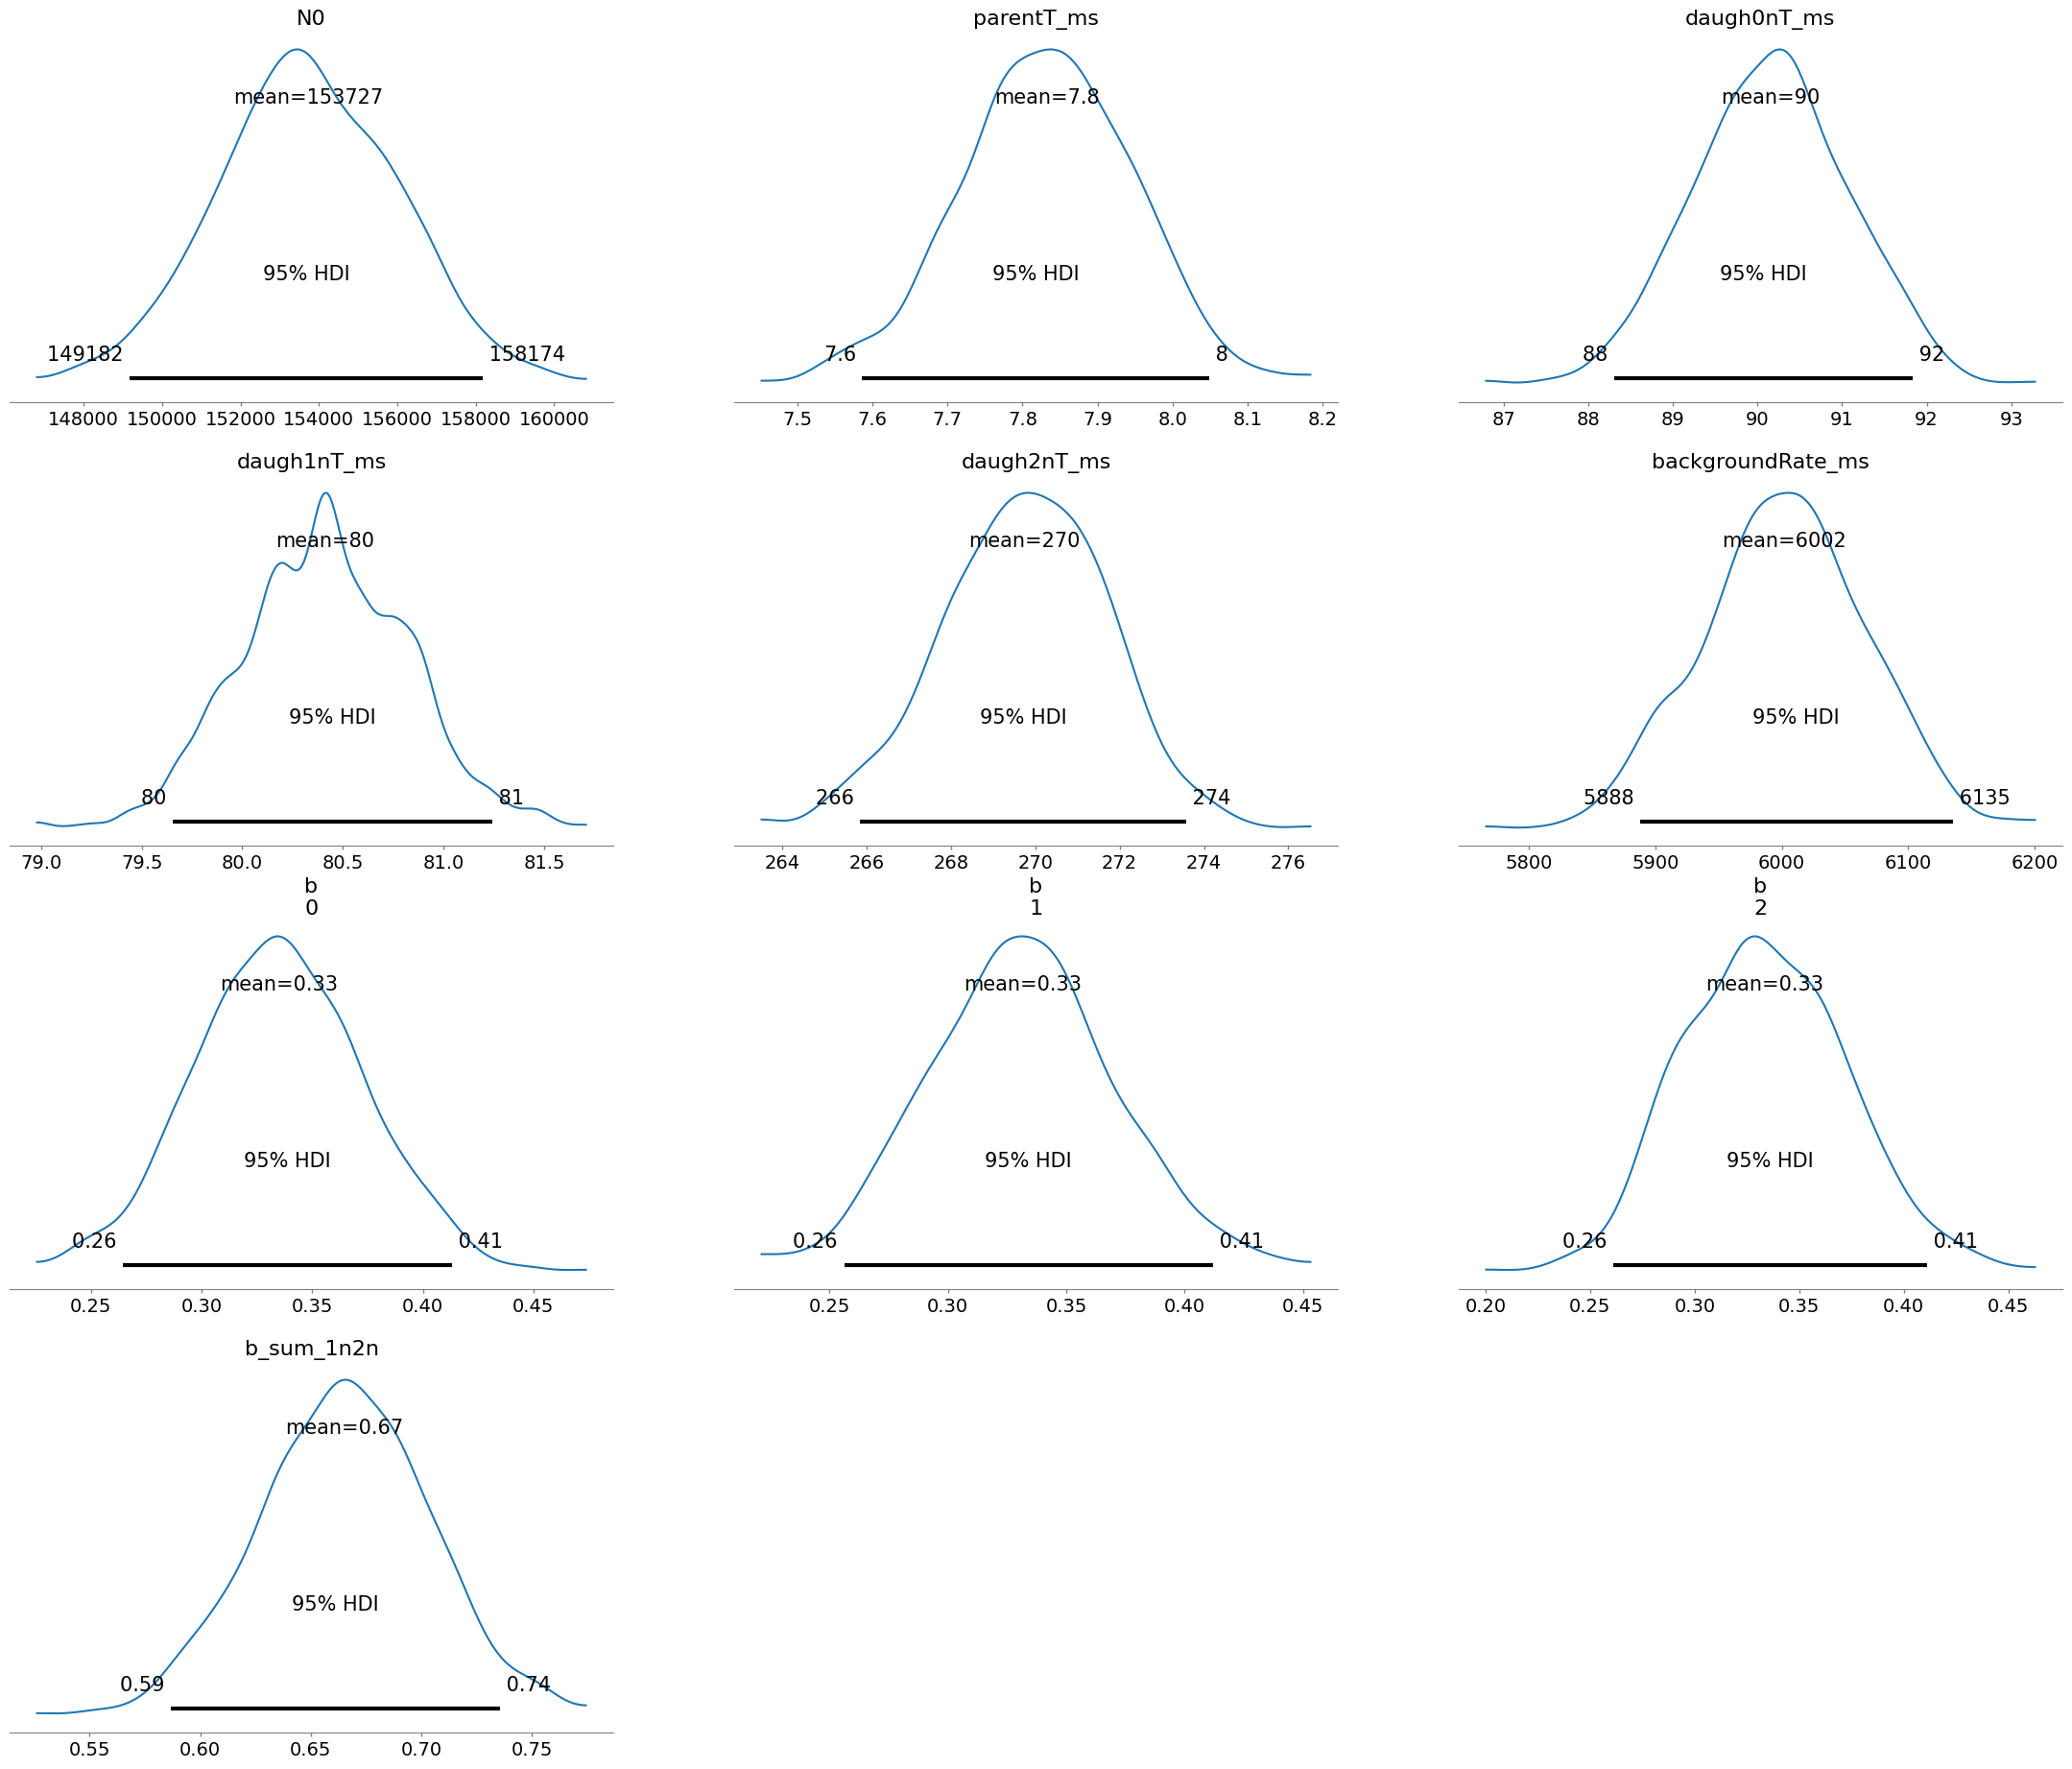

In [126]:
import arviz as az, matplotlib.pyplot as plt

pm.plot_posterior(
    idata,
    var_names=["N0", "parentT_ms", "daugh0nT_ms", "daugh1nT_ms", "daugh2nT_ms",
               "backgroundRate_ms", "b","b_sum_1n2n"],
    coords={"b_dim_0":[0,1,2]},
    hdi_prob=0.95
)
plt.show()


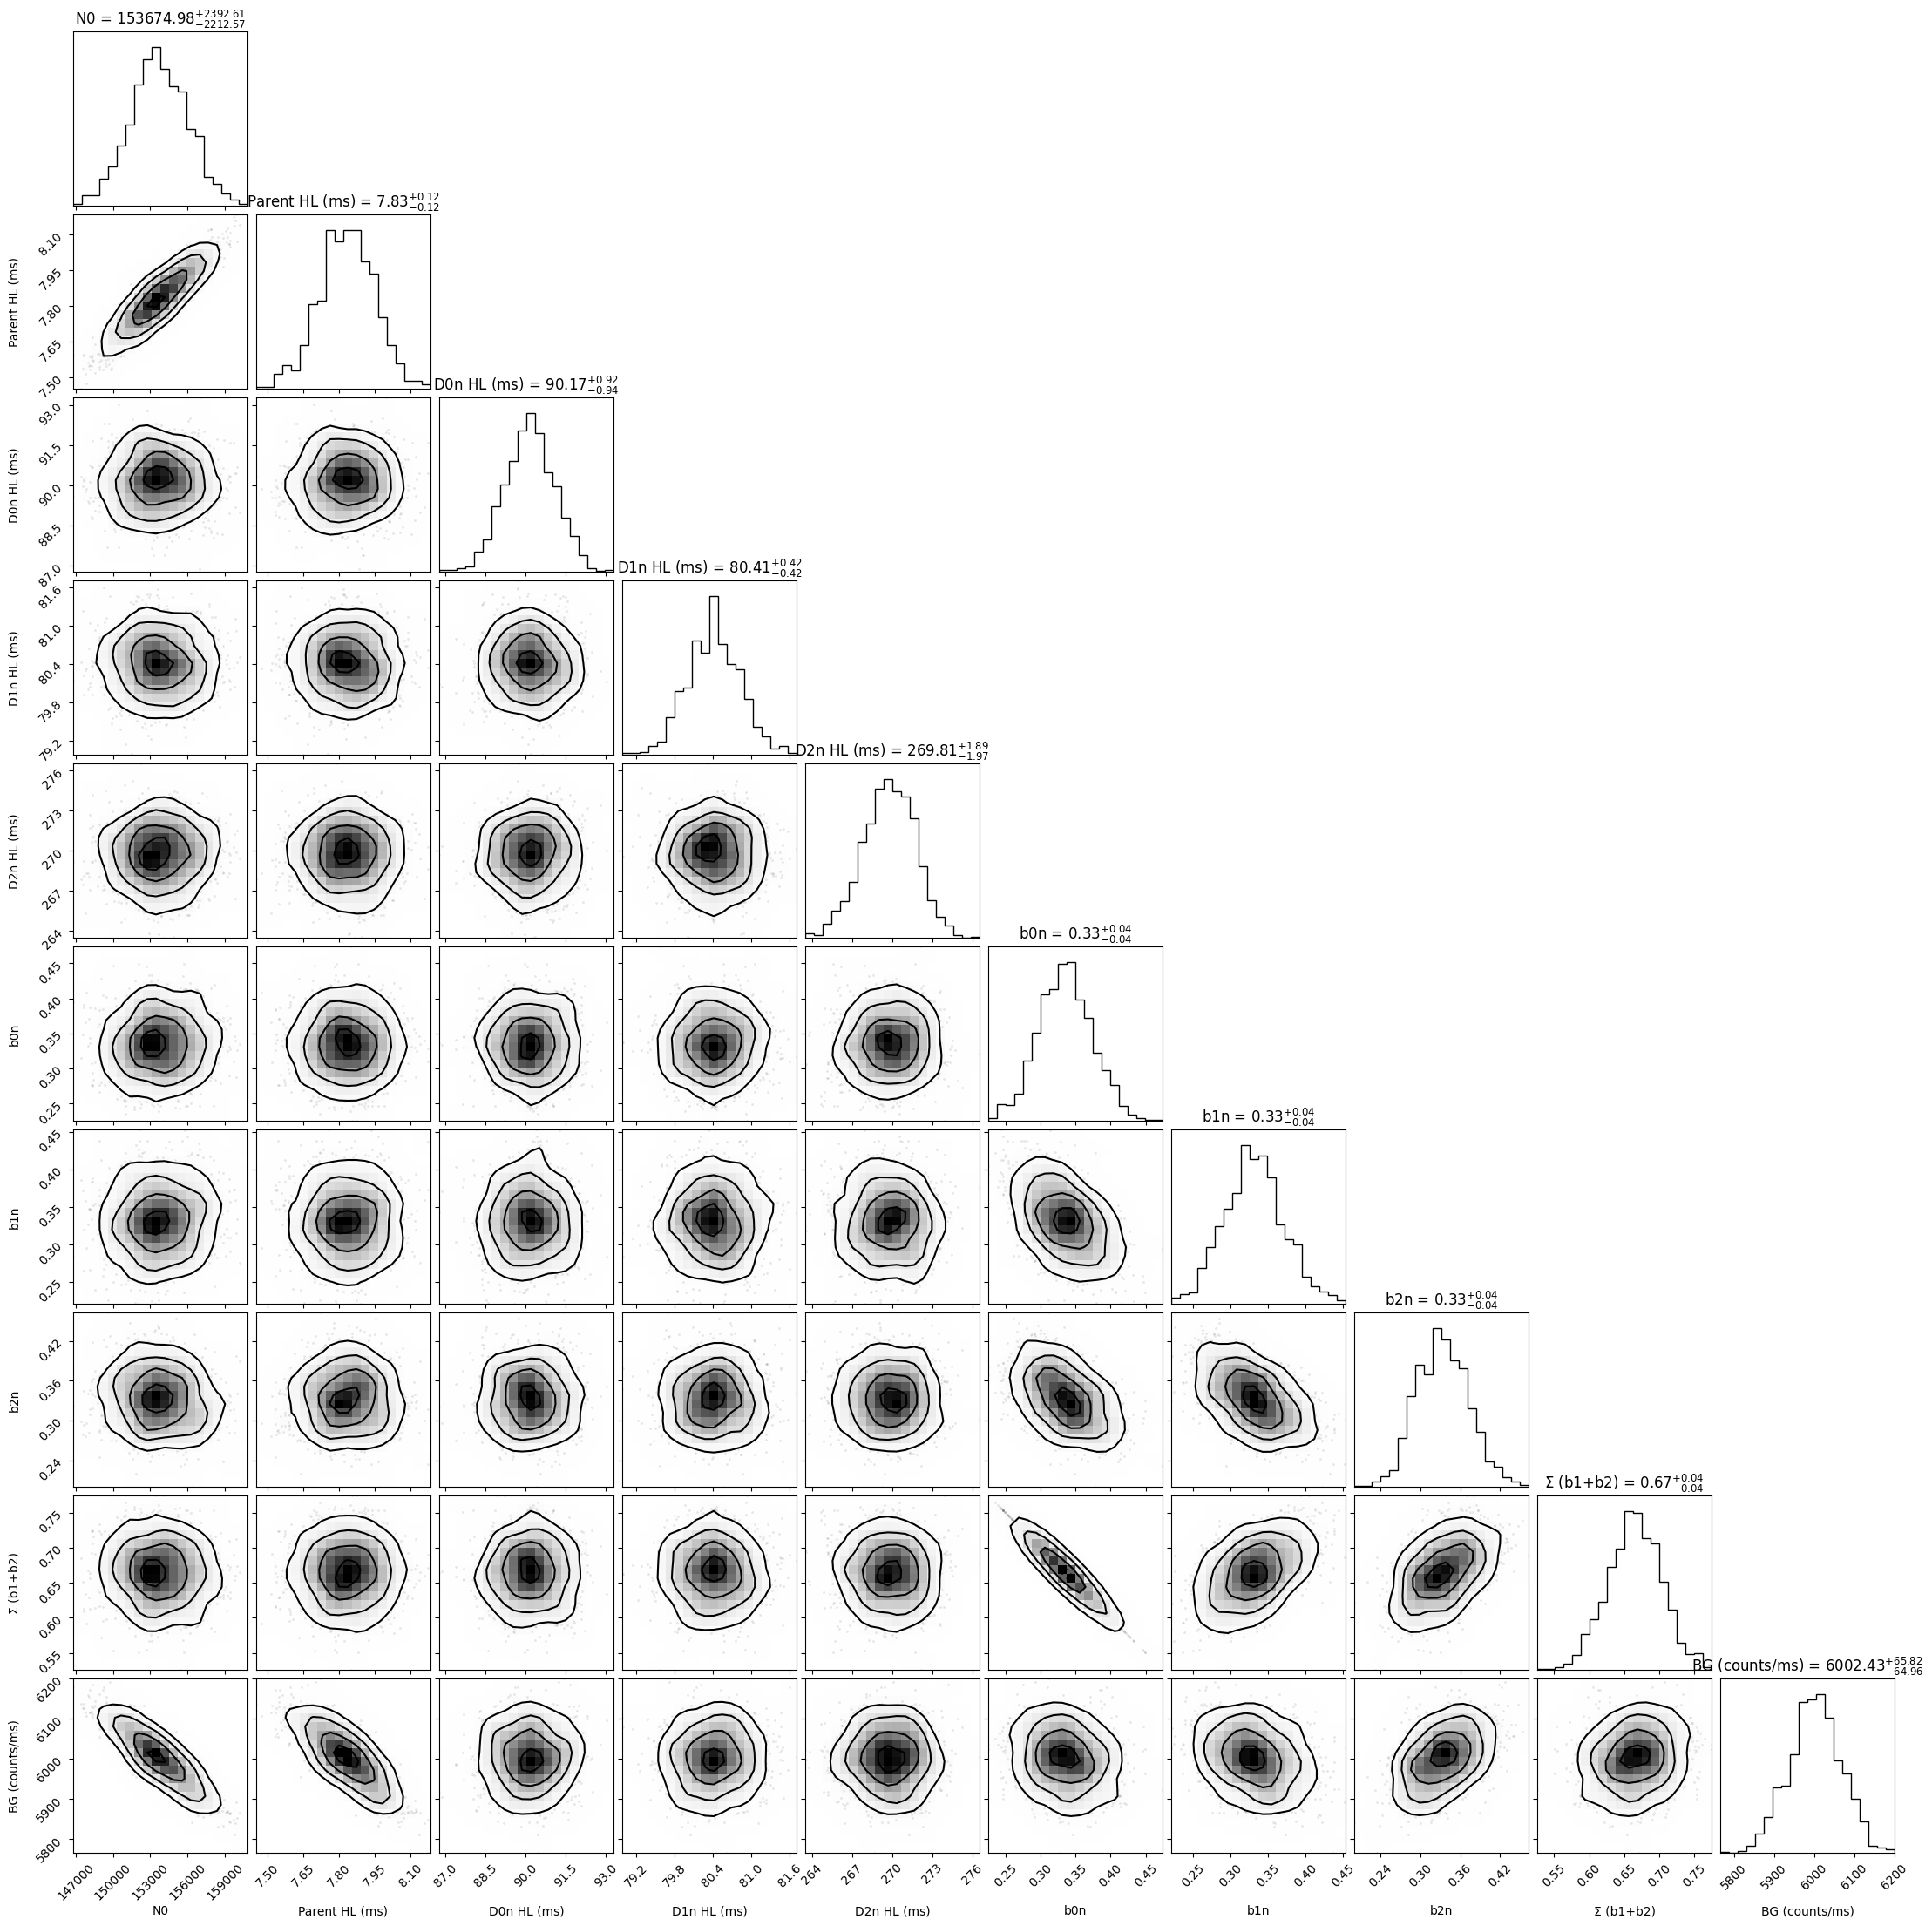

In [127]:
import numpy as np
import pandas as pd
import corner
import matplotlib.pyplot as plt

post = idata.posterior  # xarray.Dataset

# Scalars → 1D arrays (samples)
scalars = ["N0", "parentT_ms", "daugh0nT_ms", "daugh1nT_ms", "daugh2nT_ms", "backgroundRate_ms"]
samples = {}
for v in scalars:
    # stack chain & draw into a single "sample" dim, then pull to NumPy
    samples[v] = post[v].stack(sample=("chain", "draw")).values

# Vector b → 3 columns b[0], b[1], b[2]
b_vals = (
    post["b"]
    .stack(sample=("chain", "draw"))         # shape: (sample, b_dim_0) after transpose
    .transpose("sample", "b_dim_0")
    .values
)
samples["b[0]"] = b_vals[:, 0]
samples["b[1]"] = b_vals[:, 1]
samples["b[2]"] = b_vals[:, 2]
samples["b_sum"] =samples["b[1]"]+samples["b[2]"]

df = pd.DataFrame(samples)

# Optional: downsample if huge to speed up corner
# df = df.sample(n=2000, random_state=0)

cols = ["N0","parentT_ms","daugh0nT_ms","daugh1nT_ms","daugh2nT_ms",
        "b[0]","b[1]","b[2]","b_sum","backgroundRate_ms"]
labels = ["N0", "Parent HL (ms)", "D0n HL (ms)", "D1n HL (ms)", "D2n HL (ms)",
          "b0n", "b1n", "b2n", "Σ (b1+b2)", "BG (counts/ms)"]

corner.corner(
    df[cols],
    labels=labels,
    show_titles=True,
    title_fmt=".2f",
    smooth=1.0
)
plt.show()


In [162]:
import numpy as np
import aesara
import aesara.tensor as at

# From Pusa/OpenMC (order-16, IPF form)
_ALPHA_RE = at.as_tensor_variable(np.array([
  5.464930576870210e+3,  9.045112476907548e+1, 2.344818070467641e+2,
  9.453304067358312e+1,  7.283792954673409e+2, 3.648229059594851e+1,
  2.547321630156819e+1,  2.394538338734709e+1], dtype=np.float64))
_ALPHA_IM = at.as_tensor_variable(np.array([
 -3.797983575308356e+4, -1.115537522430261e+3, -4.228020157070496e+2,
 -2.951294291446048e+2, -1.205646080220011e+5, -1.155509621409682e+2,
 -2.639500283021502e+1, -5.650522971778156e+0], dtype=np.float64))

_THETA_RE = at.as_tensor_variable(np.array([
  3.509103608414918,  5.948152268951177, -5.264971343442647,
  1.419375897185666,  6.416177699099435,  4.993174737717997,
 -1.413928462488886, -10.843917078696990], dtype=np.float64))
_THETA_IM = at.as_tensor_variable(np.array([
  8.436198985884374,  3.587457362018322, 16.220221473167930,
 10.925363484496720,  1.194122393370139,  5.996881713603942,
 13.497725698892750, 19.277446167181650], dtype=np.float64))

_ALPHA0 = at.as_tensor_variable(np.array(2.124853710495224e-16, dtype=np.float64))


In [163]:
def _cram16_expm_action_one(A, t, v):
    """
    Pure Aesara: y = exp(A*t) @ v (A: [n,n], v: [n], t: scalar).
    Uses real 2n×2n block solves per complex pole (no complex dtype).
    """
    n = A.shape[0]
    I = at.eye(n, dtype=A.dtype)
    At = A * t

    # Start with alpha0 * v
    y = _ALPHA0 * v

    def pole_contrib(alpha_re, alpha_im, theta_re, theta_im, y_prev):
        # Solve [(At - a I)   b I;  -b I  (At - a I)] [u; v_] = [rhs; 0]
        a = theta_re
        b = theta_im
        rhs_top = v
        rhs_bot = at.zeros_like(v)
        top_left  = At - a * I
        top_right =  b * I
        bot_left  = -b * I
        bot_right = top_left

        M_top = at.concatenate([top_left,  top_right], axis=1)
        M_bot = at.concatenate([bot_left,  bot_right], axis=1)
        M     = at.concatenate([M_top, M_bot], axis=0)           # (2n, 2n)

        rhs = at.concatenate([rhs_top, rhs_bot], axis=0)         # (2n,)

        sol = at.linalg.solve(M, rhs)                            # (2n,)
        u   = sol[:n]
        v_  = sol[n:]

        # 2*Re(alpha * x) with x = u + i v_  → 2*(alpha_re*u - alpha_im*v_)
        contrib = 2.0 * (alpha_re * u - alpha_im * v_)
        return y_prev + contrib

    # Unroll the 8 pole contributions (small fixed count → python loop is fine)
    for k in range(8):
        y = pole_contrib(_ALPHA_RE[k], _ALPHA_IM[k], _THETA_RE[k], _THETA_IM[k], y)

    return y


In [164]:
def _cram16_expm_action_batch(A, t_vec, v):
    """
    y_i = exp(A*t_i)@v for all times in t_vec (Aesara scan).
    Returns shape (nt, n).
    """
    def step(ti, A, v):
        return _cram16_expm_action_one(A, ti, v)

    Y, _ = aesara.scan(fn=step, sequences=[t_vec], non_sequences=[A, v])
    return Y  # (nt, n)


def cram_counts_per_bin_ae(c, w, N0_parent, parentT_ms, d0_ms, d1_ms, d2_ms, b_vec, bg_rate_ms, include_parent=True):
    """
    Pure Aesara: exact counts per bin via CRAM-16 and the identity:
      ∫_a^b N(t) dt = A^{-1} [exp(A b)-exp(A a)] N0
      counts = sum_i lambda_i * X_i  (+ bg * w)
    Species order: [parent, 0n, 1n, 2n]
    """
    c = at.as_tensor_variable(c)  # (nbin,)
    w = at.as_tensor_variable(w)

    a = c - 0.5 * w
    b = c + 0.5 * w

    ln2 = at.log(2.0)
    lam_p = ln2 / parentT_ms
    lam_0 = ln2 / d0_ms
    lam_1 = ln2 / d1_ms
    lam_2 = ln2 / d2_ms
    lambdas = at.stack([lam_p, lam_0, lam_1, lam_2])

    # Build 4x4 rate matrix A
    zero = at.as_tensor_variable(0.0)
    A = at.stacklists([
        [-lam_p,       zero,       zero,       zero],
        [ b_vec[0]*lam_p, -lam_0,  zero,       zero],
        [ b_vec[1]*lam_p,  zero,  -lam_1,      zero],
        [ b_vec[2]*lam_p,  zero,   zero,      -lam_2],
    ])

    # Initial populations: only parent non-zero
    N0 = at.stack([N0_parent, zero, zero, zero])

    # exp(A*t) N0 at both edges (batch)
    Ya = _cram16_expm_action_batch(A, a, N0)      # (nbin, 4)
    Yb = _cram16_expm_action_batch(A, b, N0)      # (nbin, 4)
    Z  = (Yb - Ya)                                # (nbin, 4)
    ZT = Z.T                                      # (4, nbin)

    # Solve A X = Z (all RHS at once): X is (4, nbin) = ∫ N(t) dt over bins
    X = at.linalg.solve(A, ZT)                    # (4, nbin)

    include = at.stack([1.0 if include_parent else 0.0, 1.0, 1.0, 1.0])
    counts = at.dot((lambdas * include), X)       # (nbin,)
    counts = counts + bg_rate_ms * w
    return at.clip(counts, 1e-12, np.inf)


In [176]:
import pymc as pm

def normal_to_lognormal(mu_lin: float, sigma_lin: float):
    if mu_lin <= 0 or sigma_lin <= 0:
        raise ValueError("mu_lin and sigma_lin must be positive.")
    sigma_log = np.sqrt(np.log(1.0 + (sigma_lin / mu_lin) ** 2))
    mu_log    = np.log(mu_lin) - 0.5 * sigma_log**2
    return float(mu_log), float(sigma_log)

def build_cram_pymc_model_nuts(
    c, w, y,
    parentT_mu_ms=8.0, parentT_sigma_ms=4.0,
    daughT_mu_ms=(6.4, 7.2, 11.4),
    daughT_sigma_ms=(0.3, 0.3, 0.6),
    include_parent=True,
    use_dirichlet=False,
    bg_tail_bins=10,
    reparam_amplitudes=False,   # set True to reduce N0–b degeneracy
):
    c = np.asarray(c, float); y = np.asarray(y, int); w = np.asarray(w, float)
    if w.ndim == 0: w = np.full_like(c, float(w))

    # Convert linear → LogNormal params
    par_mu_log, par_sig_log = normal_to_lognormal(parentT_mu_ms, parentT_sigma_ms)
    d0_mu_log, d0_sig_log   = normal_to_lognormal(daughT_mu_ms[0], daughT_sigma_ms[0])
    d1_mu_log, d1_sig_log   = normal_to_lognormal(daughT_mu_ms[1], daughT_sigma_ms[1])
    d2_mu_log, d2_sig_log   = normal_to_lognormal(daughT_mu_ms[2], daughT_sigma_ms[2])

    with pm.Model() as model:
        # Data containers (keeps graph clean & allows set_data later)
        c_data = pm.MutableData("c_ms", c)
        w_data = pm.MutableData("w_ms", w)

        # Half-life priors (LogNormal, calibrated from linear mean±sd)
        parentT = pm.LogNormal("parentT_ms", mu=par_mu_log, sigma=par_sig_log)
        d0 = pm.LogNormal("daugh0nT_ms", mu=d0_mu_log, sigma=d0_sig_log)
        d1 = pm.LogNormal("daugh1nT_ms", mu=d1_mu_log, sigma=d1_sig_log)
        d2 = pm.LogNormal("daugh2nT_ms", mu=d2_mu_log, sigma=d2_sig_log)

        if reparam_amplitudes:
            # Amplitudes kill the N0–b ridge
            amp = pm.HalfNormal("amp", sigma=max(10.0, 5.0*(y.max()+1.0)), shape=3)
            b   = pm.Deterministic("b", amp / at.sum(amp))
            N0  = pm.Deterministic("N0", at.sum(amp))
        else:
            N0  = pm.HalfNormal("N0", sigma=max(10.0, 5.0*(y.max()+1.0)))
            if use_dirichlet:
                alpha = np.array([1,1, 1]) * 80.0
                b = pm.Dirichlet("b", a=alpha)
            else:
                b_mu  = np.array([1,1,1], float)
                b_raw = pm.LogNormal("b_raw", mu=np.log(b_mu), sigma=0.5, shape=3)
                b     = pm.Deterministic("b", (b_raw + 1e-12) / at.sum(b_raw + 1e-12))

        # Background prior anchored to tail median
        tail = y[-bg_tail_bins:] if y.size >= bg_tail_bins else y
        bg_per_bin = float(np.median(tail)) if tail.size > 0 else 0.0
        bg_ms_guess = max(bg_per_bin / float(np.mean(w)), 1e-6)
        bg = pm.LogNormal("backgroundRate_ms", mu=np.log(bg_ms_guess), sigma=0.7)

        # Expected counts via pure-Aesara CRAM + analytic integration
        mu_counts = cram_counts_per_bin_ae(
            c=c_data, w=w_data,
            N0_parent=N0, parentT_ms=parentT,
            d0_ms=d0, d1_ms=d1, d2_ms=d2,
            b_vec=b, bg_rate_ms=bg,
            include_parent=include_parent,
        )

        pm.Poisson("y_obs", mu=mu_counts, observed=y)

        pm.Deterministic("b0n", b[0]); pm.Deterministic("b1n", b[1])
        pm.Deterministic("b2n", b[2]); pm.Deterministic("b_sum_1n2n", b[1] + b[2])

    return model


In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import aesara.tensor as at
# Load the tab-separated file
df = pd.read_csv("hist_33Na_with_error.csv", sep="\t")
df = df.rename(columns={"# BinCenter": "BinCenter"})
df["BinContent"] = df["BinContent"].str.replace(",", "").astype(float)
df["BinError"] = df["BinError"].str.replace(",", "").astype(float)
df.head()
# Compute original bin width
diffs = df["BinCenter"].diff().dropna().unique()
bin_width = round(diffs[0], 5)
print(f"Original bin width: {bin_width} ms")

# Set desired bin width (user can modify this value)
desired_bin_width = 2
width_ms= desired_bin_width
print(f"Desired bin width: {desired_bin_width} ms")
rebin_factor = int(desired_bin_width / bin_width)

if len(df) % rebin_factor != 0:
    df = df.iloc[:-(len(df) % rebin_factor)]

# Rebin data
df_rebinned = df.groupby(np.arange(len(df)) // rebin_factor).agg({
    "BinCenter": "mean",
    "BinContent": "sum",
    "BinError": lambda x: np.sqrt(np.sum(x**2))
}).reset_index(drop=True)

df_rebinned.head()



Original bin width: 0.5 ms
Desired bin width: 2 ms


,BinCenter,BinContent,BinError
0,-99.0,10355.0,101.759547
1,-97.0,10607.0,102.990256
2,-95.0,10355.0,101.759516
3,-93.0,10352.0,101.744793
4,-91.0,10354.0,101.754573


In [179]:
# --- 1) Keep only t >= 0 for the decay fit ---
df_pos1 = df_rebinned[df_rebinned["BinCenter"] >= 0].copy()
df_pos = df_pos1[df_pos1["BinCenter"]<=40].copy()
# --- 2) Build arrays (ms → s) ---
centers_ms = df_pos["BinCenter"].to_numpy(dtype=float)
counts     = np.round(df_pos["BinContent"].to_numpy(dtype=float)).astype(int)

# Your chosen rebin width in ms (the one you just used)
width_ms = float(desired_bin_width)

centers_s = centers_ms 
width_s   = width_ms

# Sanity: Poisson needs nonnegative integers
counts[counts < 0] = 0
# Background prior scale from negative side (counts/ms)
bg_per_bin     = float(df_rebinned.loc[df_rebinned["BinCenter"] < 0, "BinContent"].mean())
bg_rate_mu_ms  = bg_per_bin / width_ms if width_ms > 0 else bg_per_bin

with build_cram_pymc_model_nuts(
    centers_ms, width_ms, counts,
    parentT_mu_ms=8.0, parentT_sigma_ms=4.0,
    daughT_mu_ms=(90.2, 80.4, 270.0),
    daughT_sigma_ms=(0.9, 0.4, 2.0),
    include_parent=True,
    use_dirichlet=False,
    bg_tail_bins=10,
    reparam_amplitudes=True,      # strongly recommended for cleaner posteriors
) as model_ms:
    idata = pm.sample(200, tune=200, chains=1, cores=1, target_accept=0.9, random_seed=42)


Only 200 samples in chain.
Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
INFO:pymc:Sequential sampling (1 chains in 1 job)
NUTS: [parentT_ms, daugh0nT_ms, daugh1nT_ms, daugh2nT_ms, amp, backgroundRate_ms]
INFO:pymc:NUTS: [parentT_ms, daugh0nT_ms, daugh1nT_ms, daugh2nT_ms, amp, backgroundRate_ms]


/projects/e21062/tg/venv/lib/python3.7/site-packages/aesara/tensor/slinalg.py:459: LinAlgWarning: Ill-conditioned matrix (rcond=7.76856e-18): result may not be accurate.
  assume_a=self.assume_a,
/projects/e21062/tg/venv/lib/python3.7/site-packages/aesara/tensor/slinalg.py:459: LinAlgWarning: Ill-conditioned matrix (rcond=3.63257e-19): result may not be accurate.
  assume_a=self.assume_a,
/projects/e21062/tg/venv/lib/python3.7/site-packages/aesara/tensor/slinalg.py:459: LinAlgWarning: Ill-conditioned matrix (rcond=7.77407e-18): result may not be accurate.
  assume_a=self.assume_a,
/projects/e21062/tg/venv/lib/python3.7/site-packages/aesara/tensor/slinalg.py:459: LinAlgWarning: Ill-conditioned matrix (rcond=3.63533e-19): result may not be accurate.
  assume_a=self.assume_a,
/projects/e21062/tg/venv/lib/python3.7/site-packages/aesara/tensor/slinalg.py:459: LinAlgWarning: Ill-conditioned matrix (rcond=1.69981e-20): result may not be accurate.
  assume_a=self.assume_a,
Sampling 1 chain for

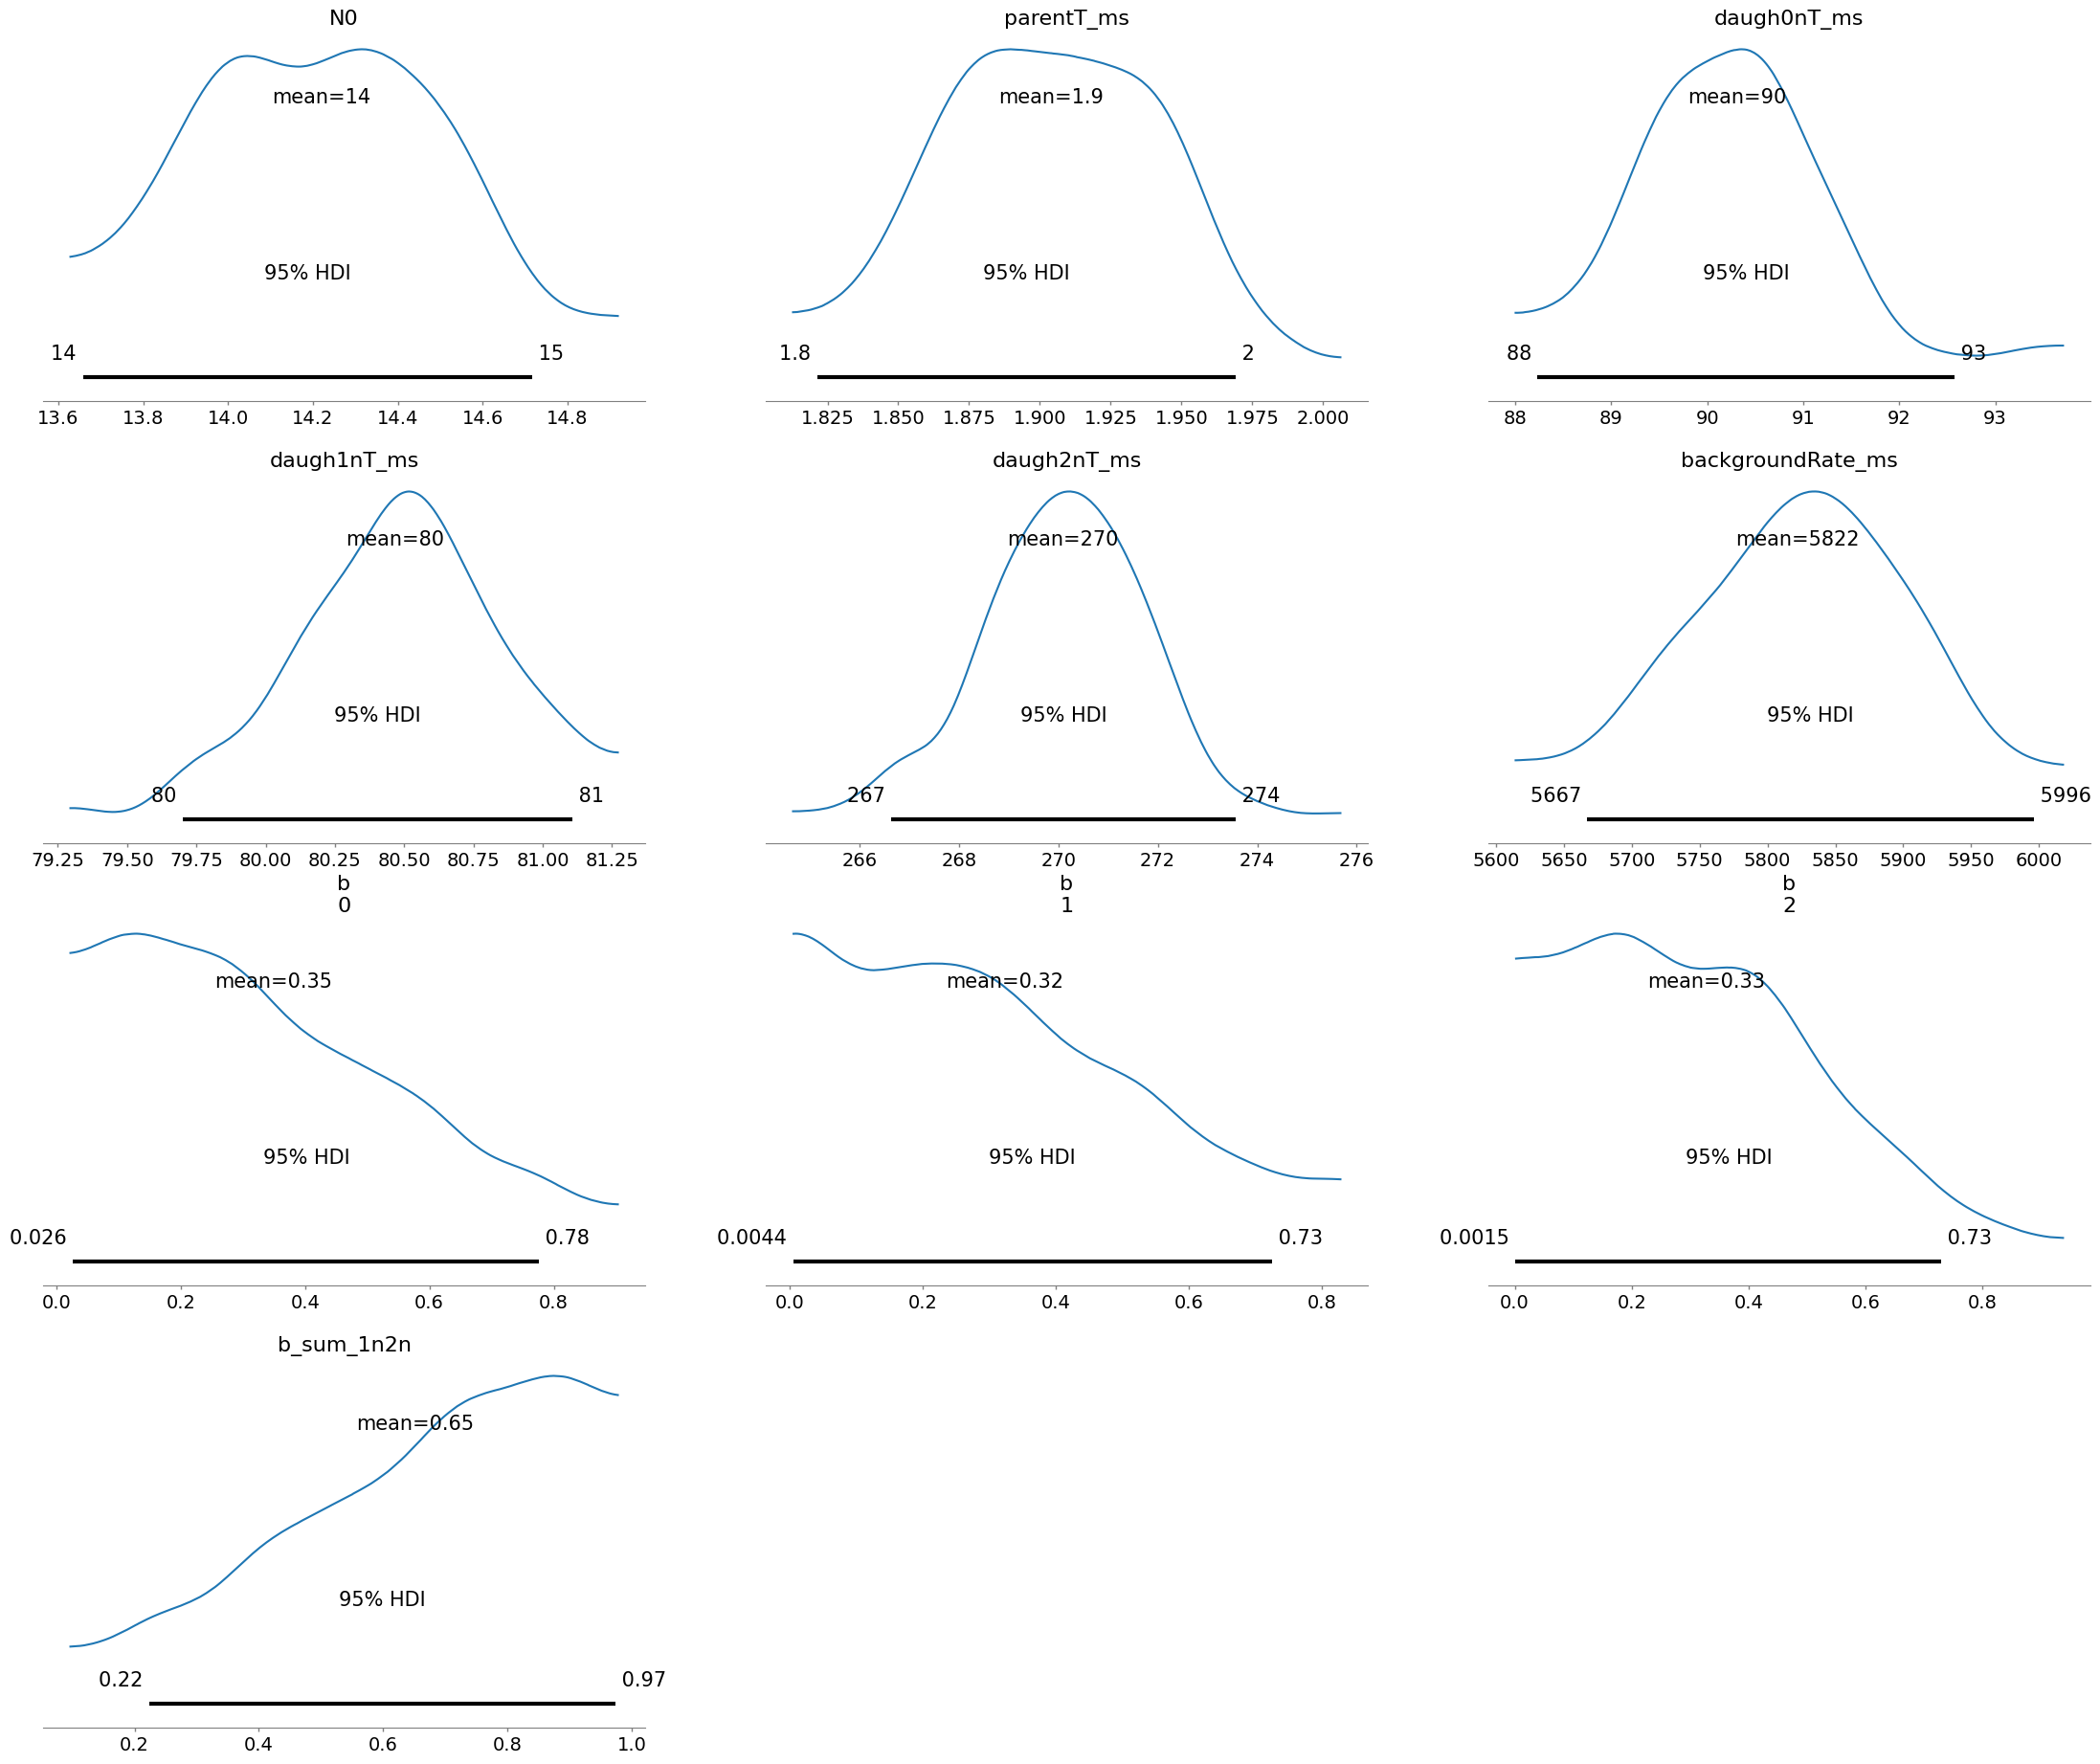

In [180]:
import arviz as az, matplotlib.pyplot as plt

pm.plot_posterior(
    idata,
    var_names=["N0", "parentT_ms", "daugh0nT_ms", "daugh1nT_ms", "daugh2nT_ms",
               "backgroundRate_ms", "b","b_sum_1n2n"],
    coords={"b_dim_0":[0,1,2]},
    hdi_prob=0.95
)
plt.show()
